Analysis of single cell RNA-seq data (Python) 
https://chanzuckerberg.github.io/scRNA-python-workshop/intro/about.html

In [1]:
import pandas as pd
## tell pandas to make a new DataFrame with the contents of `brain_counts.csv`. This might take a minute.
count_dataframe = pd.read_csv('data/brain_counts.csv', # where to find the data
                              index_col=0) # use the first column to label the rows (the 'index')
metadata_dataframe = pd.read_csv('data/brain_metadata.csv', # where to find the data
                              index_col=0)
## print the first 2 rows of our dataframe
#print(count_dataframe.head(2)) 

In [2]:
for column in metadata_dataframe.columns.values:
    print(pd.value_counts(metadata_dataframe[column]))

oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          432
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
Bergmann glial cell                 40
Name: cell_ontology_class, dtype: int64
Cortex         1149
Hippocampus     976
Striatum        723
Cerebellum      553
Name: subtissue, dtype: int64
M    2694
F     707
Name: mouse.sex, dtype: int64
3_10_M    980
3_9_M     871
3_8_M     590
3_38_F    355
3_11_M    253
3_39_F    241
3_56_F    111
Name: mouse.id, dtype: int64
MAA000560    287
MAA000926    263
MAA000581    190
MAA000944    184
MAA000932    174
MAA001894    147
MAA000564    143
MAA000942    136
MAA000935    131
MAA000941    125
MAA000930    111
MAA000923    108
MAA000947    107
B003290       98
MAA000561     97
MAA000615     95
B003275       93
MAA000641     67
B003728       66
MAA000940     63
MAA001895     60
MAA000563     57
MAA000925     55
B003277  

In [3]:
import scanpy as sc
adata = sc.AnnData(X = count_dataframe, obs = metadata_dataframe)
print(adata)

AnnData object with n_obs × n_vars = 3401 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'


Labeling spike-ins

Because this is smartseq2 data, we may have spike-ins. These gene names start with ERCC. We can label them in adata.var as a gene annotation.

In [4]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True # record that we found a spike-in
        number_of_spike_ins += 1 # bump the counter
    else:
        is_spike_in[gene_name] = False # record that this was not a spike-in
        
adata.var['ERCC'] = pd.Series(is_spike_in) # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many spike ins: ', number_of_spike_ins)

found this many spike ins:  92


In [5]:
adata.write('data/brain_raw.h5ad')

# Quality control

In [6]:
import scanpy as sc # import scanpy to handle our AnnData 
import pandas as pd # import pandas to handle dataframes
import matplotlib.pyplot as plt # import matplotlib to visualize our qc metrics

# magic incantation to help matplotlib work with our jupyter notebook
%matplotlib inline 
adata = sc.read('data/brain_raw.h5ad')

In [7]:
qc = sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'])# this returns a tuple of (cell_qc_dataframe, gene_qc_dataframe)
                                 # ask for the percentage of reads from spike ins
                                
cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

print('This is the cell quality control dataframe:')
print(cell_qc_dataframe.head(2))

print('\n\n\n\nThis is the gene quality control dataframe:')
print(gene_qc_dataframe.head(2))

This is the cell quality control dataframe:
                       n_genes_by_counts  log1p_n_genes_by_counts  \
cell                                                                
A1.B003290.3_38_F.1.1               3359                 8.119696   
A1.B003728.3_56_F.1.1               1718                 7.449498   

                       total_counts  log1p_total_counts  \
cell                                                      
A1.B003290.3_38_F.1.1        390075           12.874097   
A1.B003728.3_56_F.1.1        776439           13.562475   

                       pct_counts_in_top_50_genes  \
cell                                                
A1.B003290.3_38_F.1.1                   25.884766   
A1.B003728.3_56_F.1.1                   43.051933   

                       pct_counts_in_top_100_genes  \
cell                                                 
A1.B003290.3_38_F.1.1                    32.847017   
A1.B003728.3_56_F.1.1                    52.912721   

            

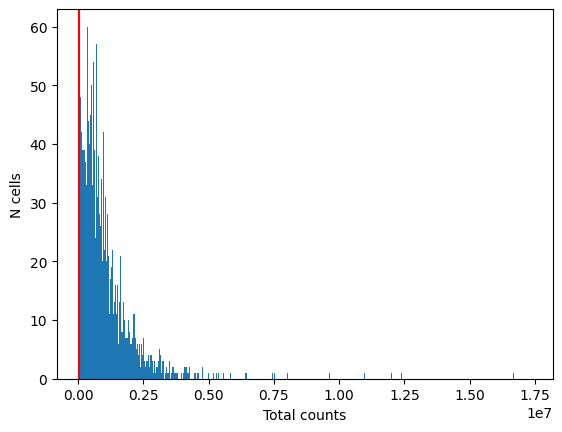

In [27]:
#First, we consider the total number of reads detected per cell.
#Cells with few reads are likely to have 
#been broken or failed to capture a cell, and should thus be removed
plt.hist(cell_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(50000, color='red') # Looks like the authors have already 
#removed cells with fewer than 50,000 reads.

In addition to ensuring sufficient sequencing depth for each sample, we also want to make sure that the reads are distributed across the transcriptome. Thus, we count the total number of unique genes detected in each sample.

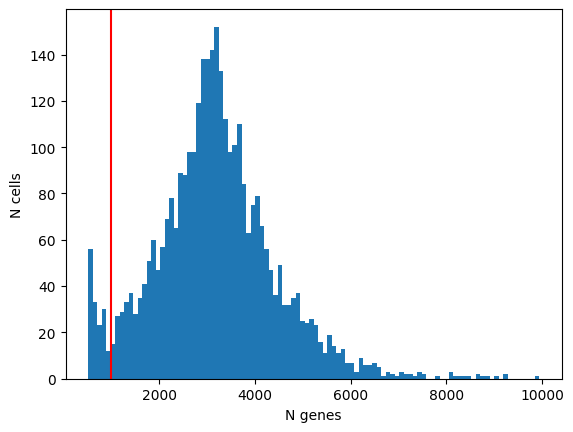

In [28]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(1000, color='red')

Another measure of cell quality is the ratio between ERCC spike-in RNAs and endogenous RNAs. This ratio can be used to estimate the total amount of RNA in the captured cells. Cells with a high level of spike-in RNAs had low starting amounts of RNA, likely due to the cell being dead or stressed which may result in the RNA being degraded.

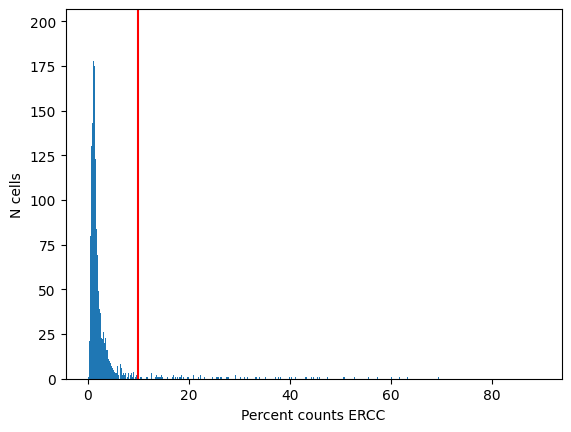

In [29]:
plt.hist(cell_qc_dataframe['pct_counts_ERCC'], bins=1000)
plt.xlabel('Percent counts ERCC')
plt.ylabel('N cells')
plt.axvline(10, color='red')

There isn't an automatic function for removing cells with a high percentage of ERCC reads, but we can use a mask to remove them like so:

In [8]:
low_ERCC_mask = (cell_qc_dataframe['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]
print('Started with: \n', adata)
sc.pp.filter_cells(adata, min_genes = 750)
print('Finished with: \n', adata)

Started with: 
 View of AnnData object with n_obs × n_vars = 3218 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'


/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Finished with: 
 AnnData object with n_obs × n_vars = 3210 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'


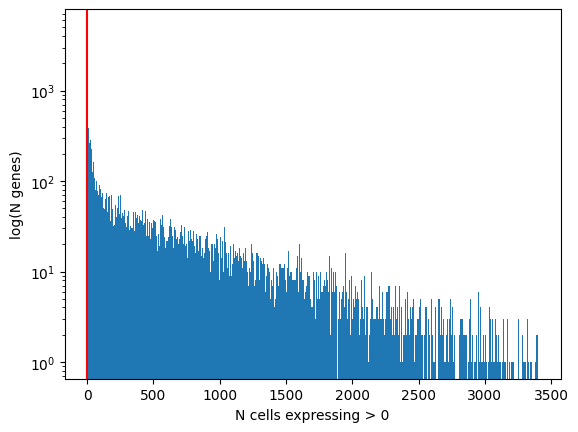

In [31]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') # for visual clarity
plt.axvline(2, color='red')
plt.yscale('log') 

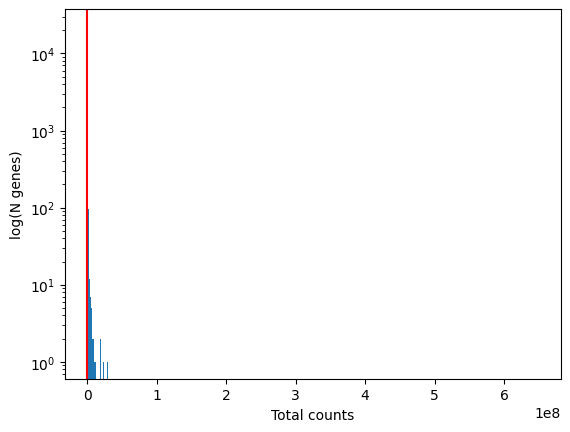

In [32]:
plt.hist(gene_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('log(N genes)') # for visual clarity
plt.yscale('log') 
plt.axvline(10, color='red')

In [9]:
print('Started with: \n', adata)
sc.pp.filter_genes(adata, min_cells = 2)
sc.pp.filter_genes(adata, min_counts = 10)
print('Finished with: \n', adata)

Started with: 
 AnnData object with n_obs × n_vars = 3210 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'
Finished with: 
 AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC', 'n_cells', 'n_counts'


In [10]:
adata.write('data/brain_qc.h5ad')

# Normalization & PCA 

In [11]:
import scanpy as sc
adata=sc.read('data/brain_qc.h5ad')

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


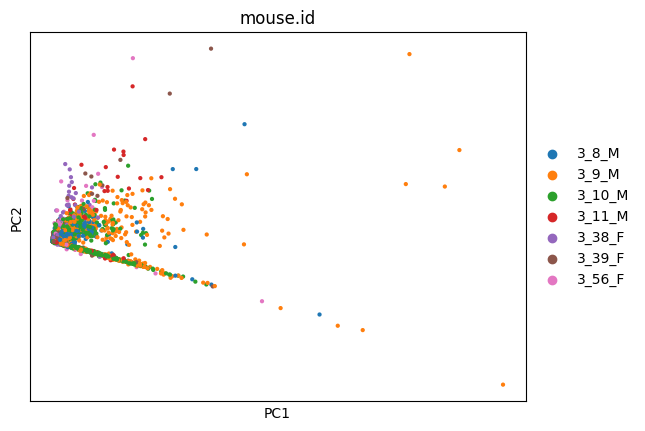

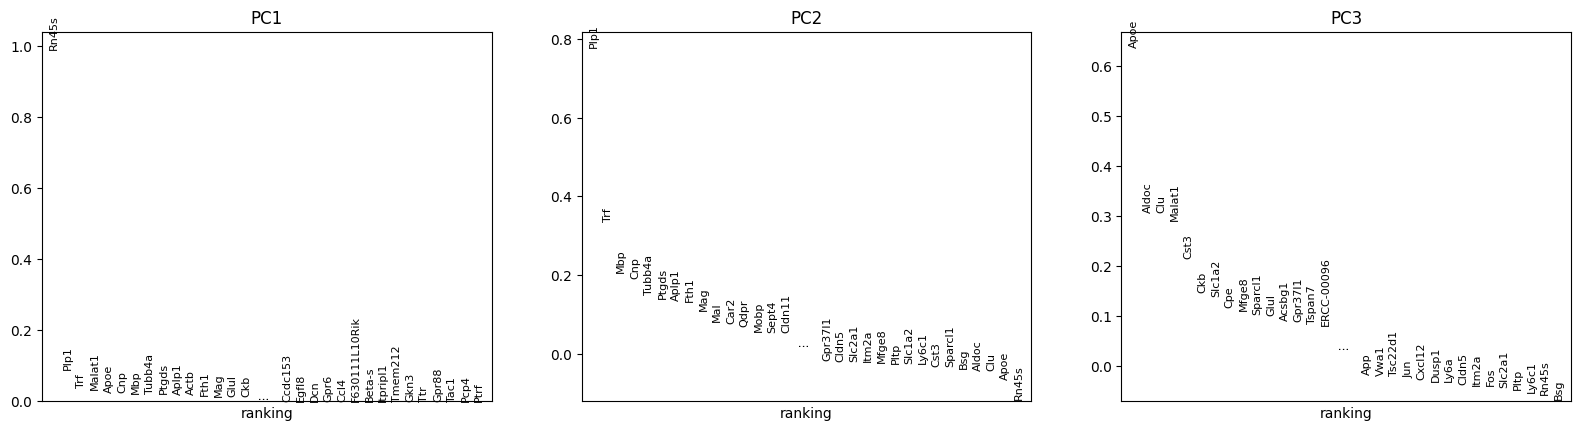

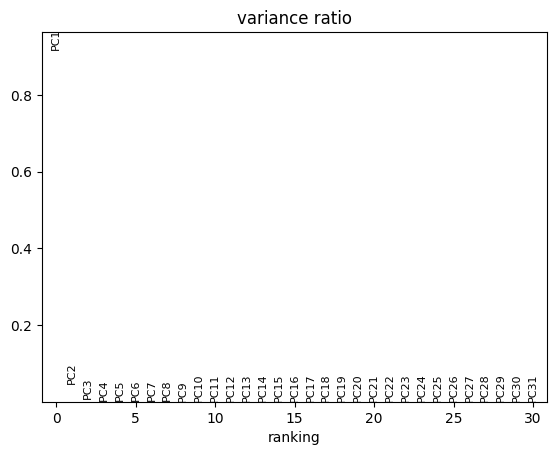

In [12]:
#Let's first peek at our data before normalization:
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='mouse.id')


## CPM

The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.

Use the SCANPY function sc.pp.normalize_total() to normalize with counts per million, excluding highly expressed genes from the size factor calculation.

Visualize the output with PCA.

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


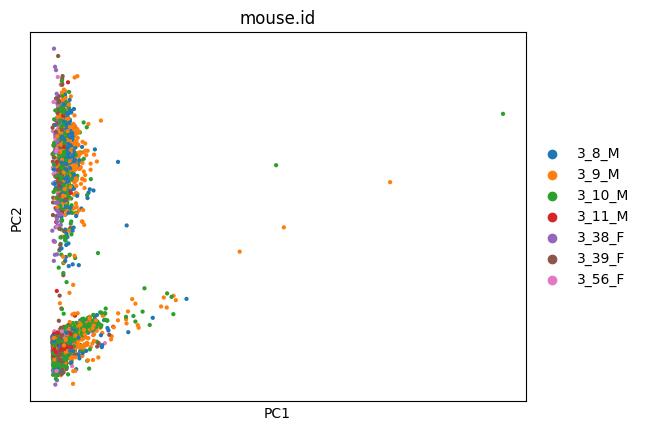

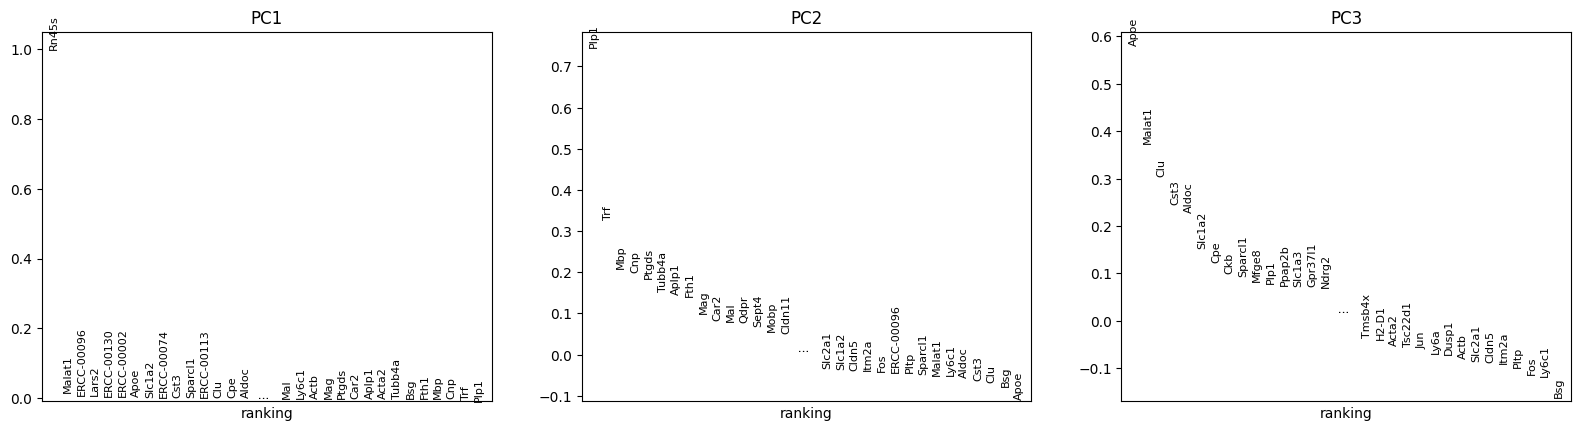

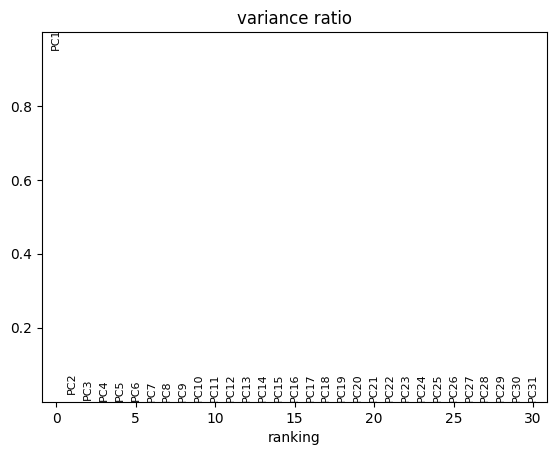

In [13]:
adata_cpm = adata.copy() # make a copy so we can compare results
adata_cpm.raw = adata_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_total(adata_cpm, target_sum=1e6, exclude_highly_expressed=True) # normalize
sc.pp.pca(adata_cpm) # run pca
sc.pl.pca_overview(adata_cpm, color='mouse.id') # plot pca

As we saw earlier, this dataset is dominated by one or more highly expressed genes. One thing to test is to determine if the offending gene, Rn45s, when removed, yields a more reasonable analysis. This can be assessed by removing the gene and re-running PCA.

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


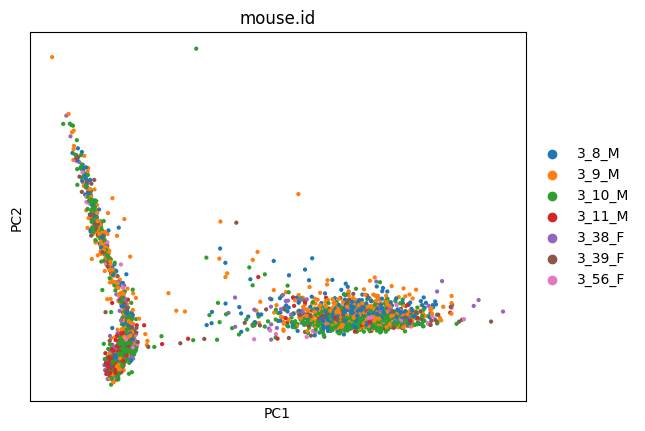

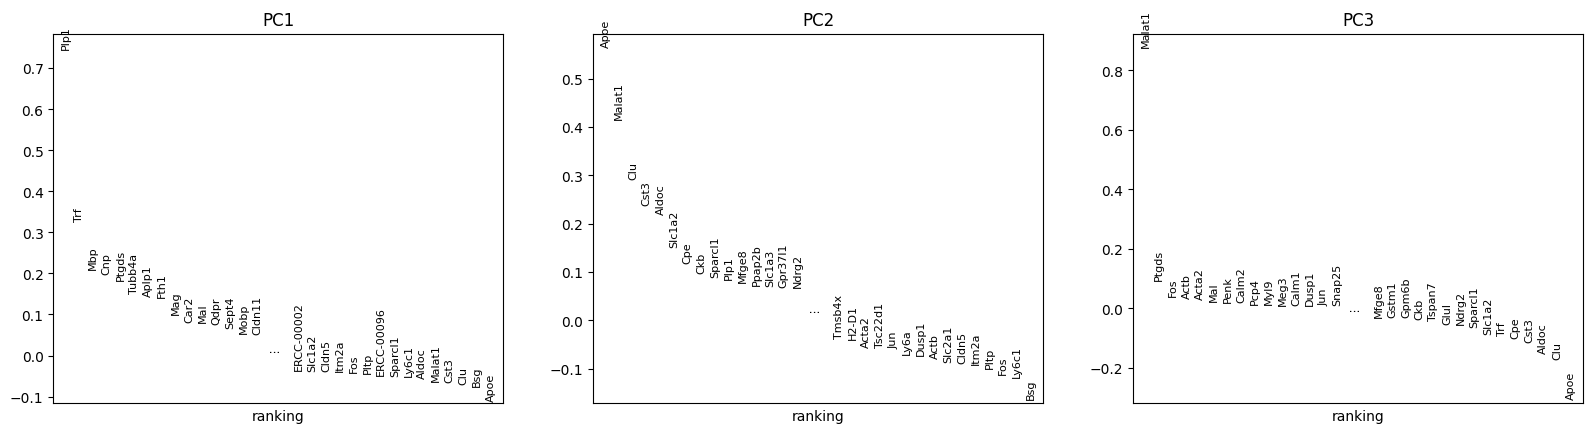

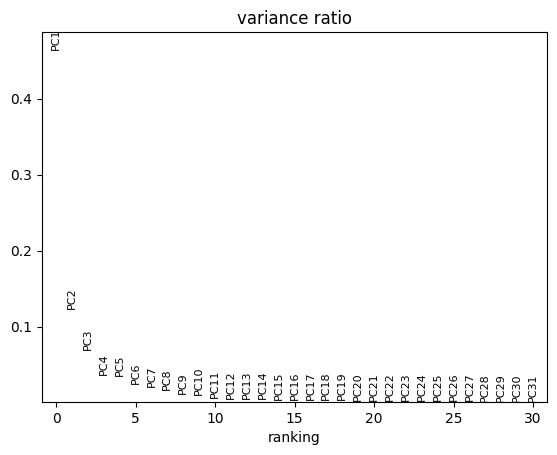

In [14]:
not_Rn45s = adata_cpm.var.index != 'Rn45s'
adata_no_Rn45s = adata_cpm[:, not_Rn45s]

sc.pp.pca(adata_no_Rn45s)
sc.pl.pca_overview(adata_no_Rn45s, color='mouse.id')

First, we take the log(1+x) of each value. The +1 makes sure that 0 values in the original data still map to 0 in log space (and prevents us from trying to take the log of 0). This makes the expression values more closely approximate a Gaussian distribution, which is an assumption inherent to many downstream analysis methods.

Then for each gene, we subtract the mean expression value and divide by the standard deviation.

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


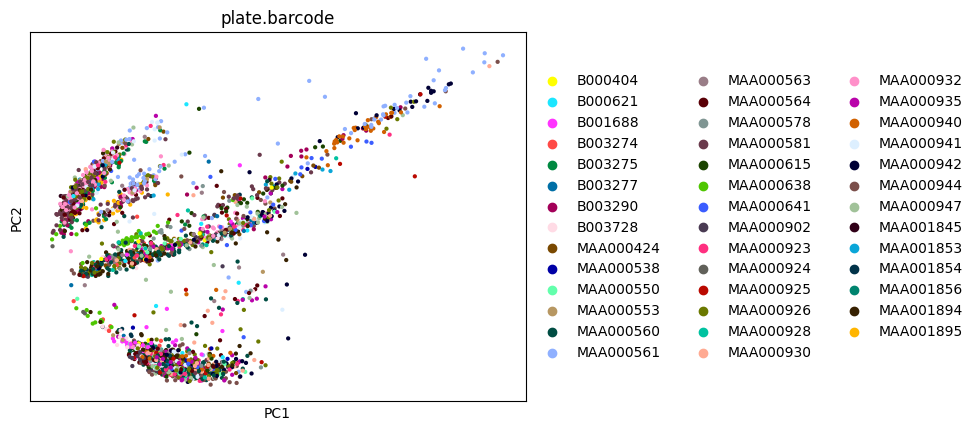

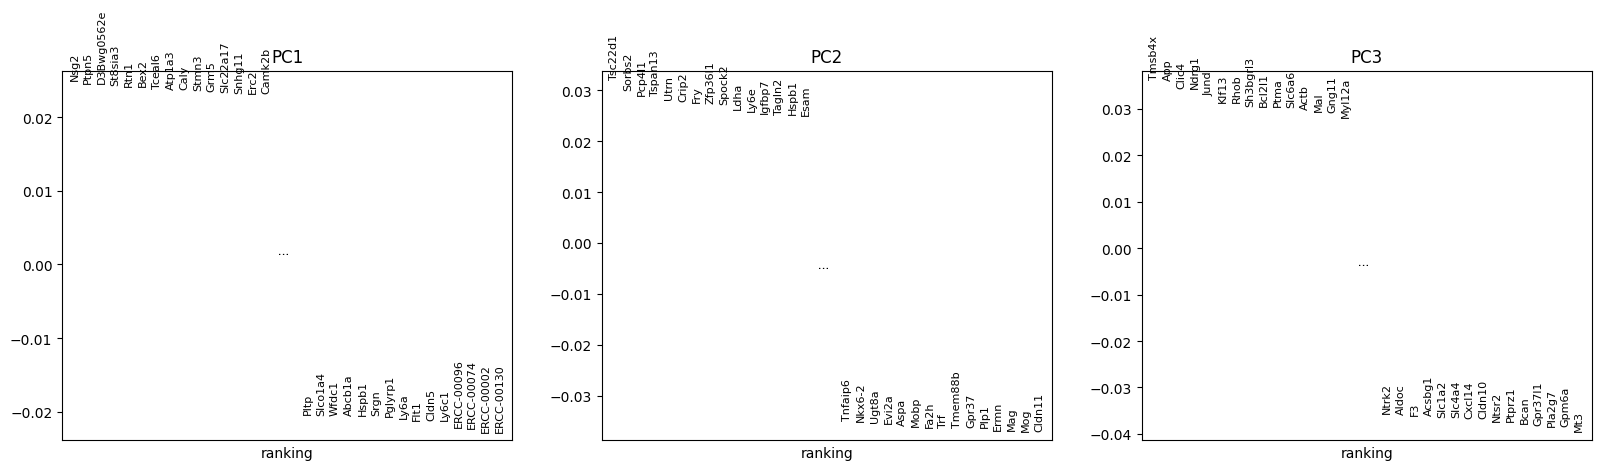

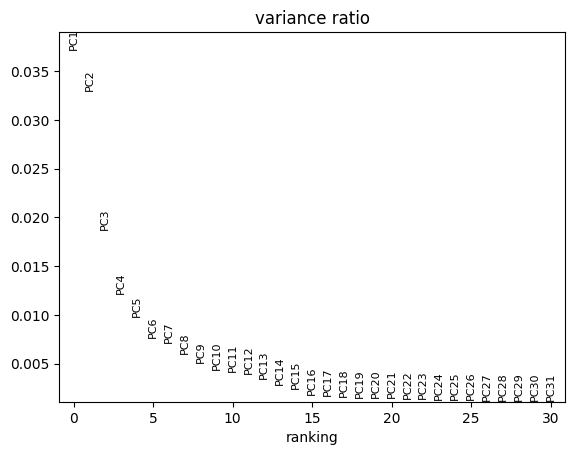

In [15]:
sc.pp.log1p(adata_cpm)
sc.pp.scale(adata_cpm)

sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='plate.barcode')

In [16]:
adata_cpm.write('data/brain_normalized.h5ad')

# Dimensionality reduction 

In [17]:
import scanpy as sc
adata = sc.read('data/brain_normalized.h5ad')

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


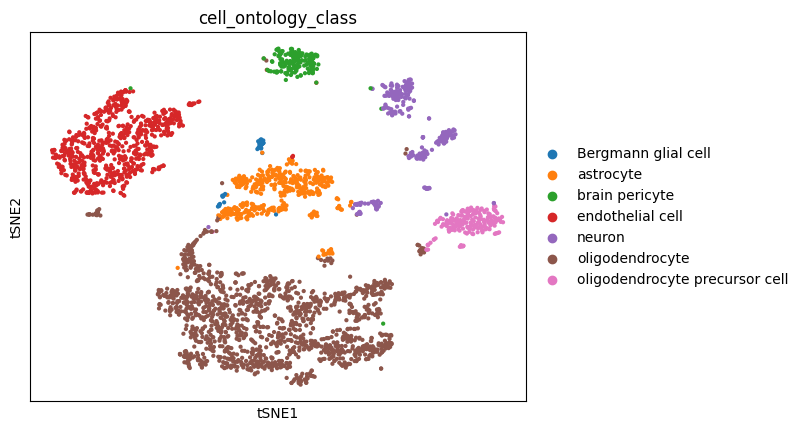

In [18]:
#t-SNE
sc.tl.tsne(adata, perplexity=30, learning_rate=1000, random_state=0)
sc.pl.tsne(adata, color='cell_ontology_class')

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


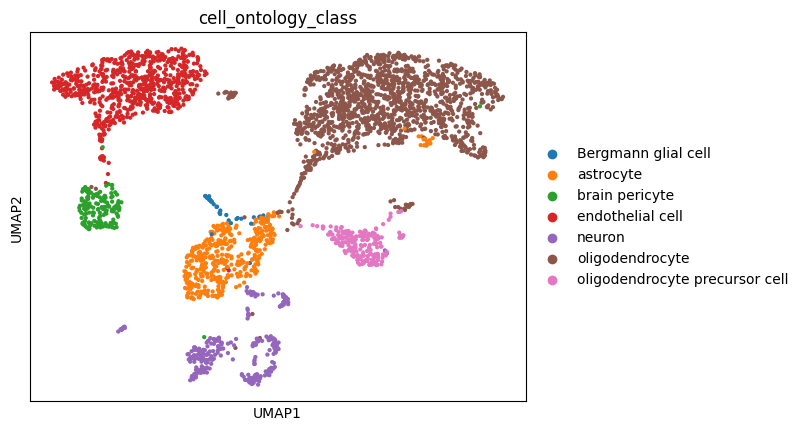

In [18]:
#UMAP
sc.pp.neighbors(adata) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

In [19]:
adata.write('data/brain_embeddings.h5ad')

# Clustering 

In [20]:
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
%matplotlib inline

adata = sc.read('data/brain_embeddings.h5ad')

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


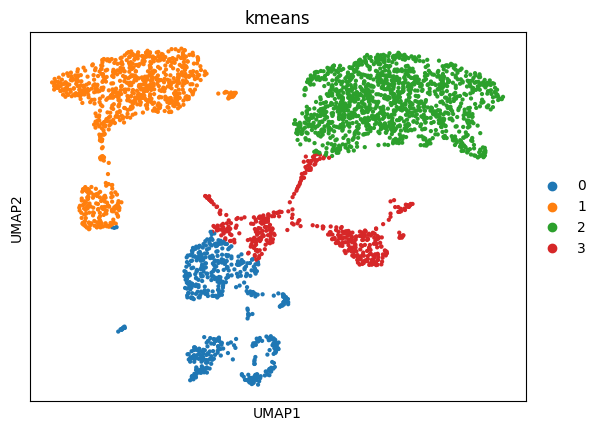

In [21]:
umap_coordinates = adata.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

Evaluating clustering

Intuitively, we can see from the plot that our value of k (the number of clusters) is probably too low.

This dataset has "ground truth" cell type labels available. We can use these to assess our cluster labels a bit more rigorously using the adjusted Rand index. This index is a measure between (0, 1) which indicates the similarity between two sets of categorical labels (e.g., our cell type labels and cluster labels). A value of 1 means the two clusterings are identical, and 0 means the level of similarity expected by random chance.


In [22]:
rand_index = adjusted_rand_score(labels_true = adata.obs['cell_ontology_class'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.78


Graph-based methods

Graph-based methods attempt to partition a pre-computed neighhbor graph into modules (i.e., groups / clusters of cells) based on their connectivity. Currently, the most widely used graph-based methods for single cell data are variants of the louvain algorithm. The intuition behind the louvain algorithm is that it looks for areas of the neighbor graph that are more densely connected than expected (based on the overall connectivity in the graph).

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


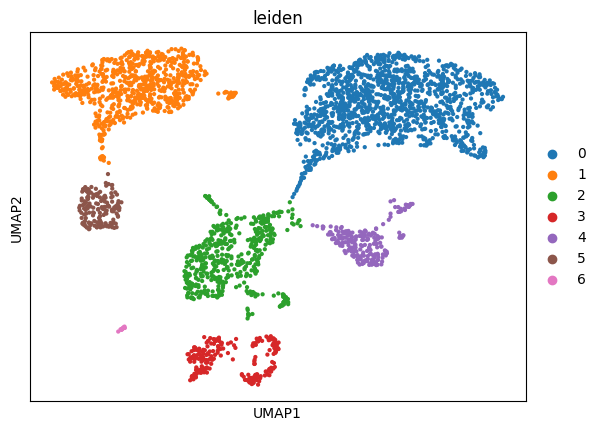

The rand index is  0.91


In [23]:
sc.tl.leiden(adata,resolution=0.1)
sc.pl.umap(adata, color='leiden')
rand_index = adjusted_rand_score(adata.obs['cell_ontology_class'], adata.obs['leiden'])
print('The rand index is ', round(rand_index, 2))

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


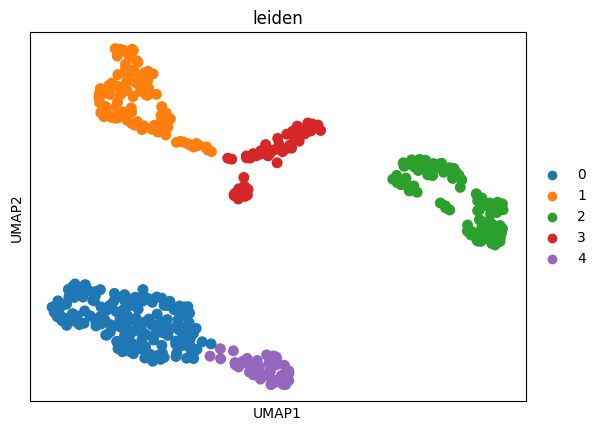

The rand index is  0.95


In [24]:
cerebellum = adata[adata.obs['subtissue'] == 'Cerebellum']
sc.pp.neighbors(cerebellum)
sc.tl.umap(cerebellum)

sc.tl.leiden(cerebellum,resolution=0.1)
sc.pl.umap(cerebellum, color='leiden')
rand_index = adjusted_rand_score(cerebellum.obs['cell_ontology_class'], cerebellum.obs['leiden'])
print('The rand index is ', round(rand_index, 2))

In [25]:
sc.tl.leiden(adata, resolution=0.1)
adata.write('data/brain_clusters.h5ad')

# Differential expression & cluster annotation 

With differential expression, we want to account for both the center and spread of the expression in each group. Recall that when we normalized our values, we standardized the distribution of each gene across cells to be centered at 0 and scaled with variance 1. So, when calculating differential expression, we should use the raw values (post-QC, pre-normalization). We saved these in adata.raw earlier on.

In [32]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

adata = sc.read('data/brain_clusters.h5ad')
adata.uns['log1p']["base"] = None
raw = pd.DataFrame(data=adata.raw.X, index=adata.raw.obs_names, columns=adata.raw.var_names)

In [27]:
print(adata.raw)

Raw AnnData with n_obs × n_vars = 3210 × 18585
    var: 'ERCC', 'n_cells', 'n_counts'
    varm: 'PCs'


we have a cluster of interest, and we want to determine if they are astrocytes. Let's start by plotting the distibution of a marker gene's expression in the cluster compared to the rest of the dataset.

In [33]:
astrocyte_marker = 'Gja1' # define genes of interest
# housekeeping = 'Chmp2a' 

cluster2 = raw[adata.obs['leiden'] == '2'] # Use a mask to subset dataset to cells assigned to cluster 2
not_cluster2 = raw[adata.obs['leiden'] != '2'] # All other cells

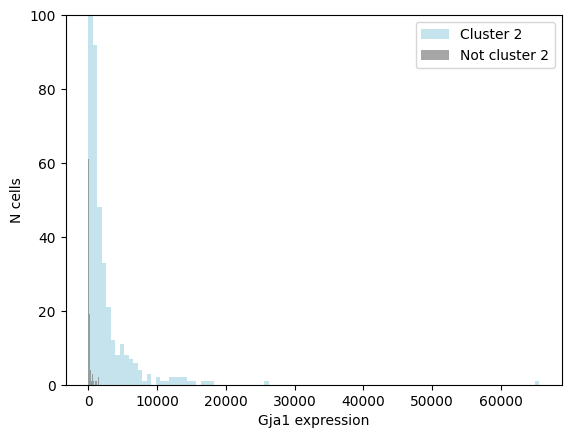

In [34]:
cluster2_marker_exp = cluster2[astrocyte_marker] 
plt.hist(cluster2_marker_exp.values, bins=100, color='lightblue', alpha=0.7, label='Cluster 2') # Plot distribution

not_cluster2_marker_exp = not_cluster2[astrocyte_marker]
plt.hist(not_cluster2_marker_exp, bins=100, color='gray', alpha=0.7, label='Not cluster 2')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%astrocyte_marker) # label our axes
plt.ylabel('N cells')
plt.legend()

 how do we decide whether this cluster is actually "differentially expressing" our marker gene?
 Because we expect the differences in expression to be relatively large for marker genes, we can use straightforward hypothesis testing methods to ask for the probability (p-value) that we would observe this level of differential expression if all these cells were, in fact, the same population (i.e., if the null hypothesis were true).

In [35]:
from scipy.stats import ttest_ind

ttest = ttest_ind(cluster2_marker_exp, 
          not_cluster2_marker_exp, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

Ttest_indResult(statistic=10.507538228573805, pvalue=1.928306883278798e-23)


/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ag1028/demo/notebook

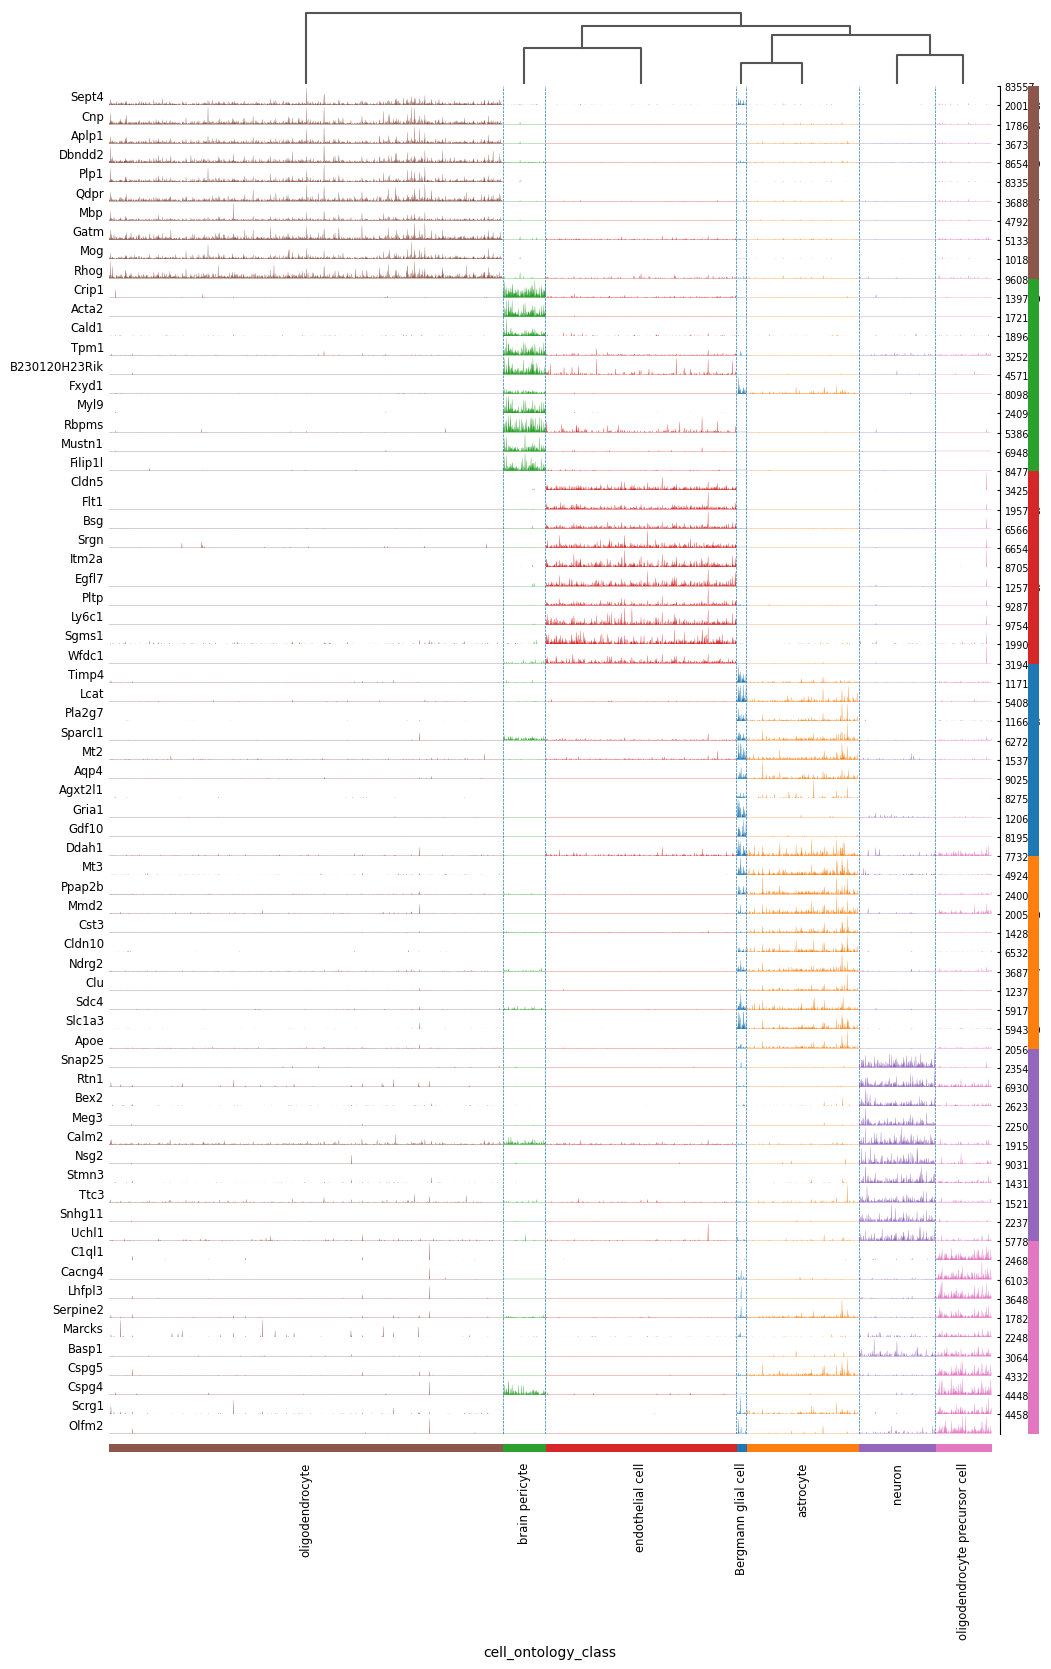

In [36]:
sc.tl.rank_genes_groups(adata, groupby='cell_ontology_class', use_raw=True, 
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
sc.pl.rank_genes_groups_tracksplot(adata, groupby='cell_ontology_class') # plot the result


Comparing to "known" marker genes

We can also compare these data-driven marker genes to those considered by the field to be classic indicators of cell type.


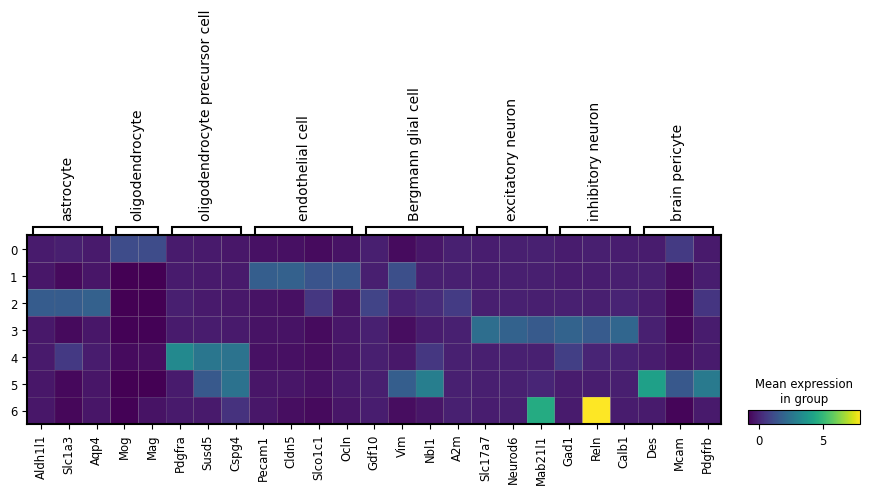

In [38]:
marker_genes = {
'astrocyte': ['Aldh1l1', 'Slc1a3', 'Aqp4'], 
'oligodendrocyte': ['Mog','Mag'],
'oligodendrocyte precursor cell': ['Pdgfra','Susd5','Cspg4'],
'endothelial cell': ['Pecam1','Cldn5','Slco1c1','Ocln'],
'Bergmann glial cell': ['Gdf10','Vim','Nbl1','A2m'],
'excitatory neuron': ['Slc17a7','Neurod6','Mab21l1'],
'inhibitory neuron': ['Gad1','Reln','Calb1'],
'brain pericyte': ['Des','Mcam','Pdgfrb']
}

sc.pl.matrixplot(adata, marker_genes, groupby='leiden', use_raw=False)